# Conditional DDPM on MNIST with Text Labels

## Import Libraries and Set Device

Import all required libraries and set the device (GPU or CPU) for training.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from transformers import AutoTokenizer, AutoModel
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Prepare MNIST Dataset with Text Prompts

This cell creates a custom dataset that pairs each MNIST digit with a descriptive text prompt (e.g., "a handwritten number three"). It also visualizes a few random samples from the training set to confirm the data and text-label mapping.

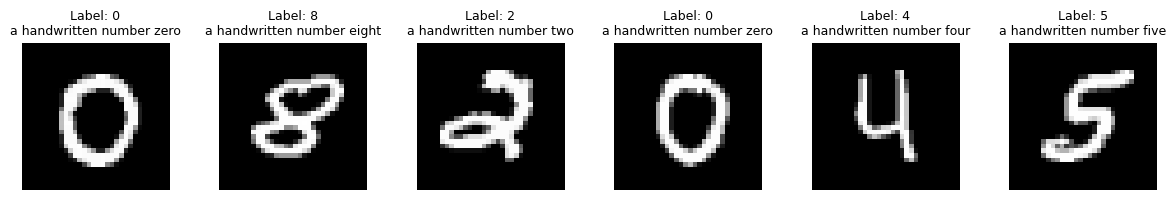

In [ ]:
# Map digit to descriptive text prompt
digit_to_text = {
    0: "a handwritten number zero",
    1: "a handwritten number one",
    2: "a handwritten number two",
    3: "a handwritten number three",
    4: "a handwritten number four",
    5: "a handwritten number five",
    6: "a handwritten number six",
    7: "a handwritten number seven",
    8: "a handwritten number eight",
    9: "a handwritten number nine"
}

class MNISTWithText(Dataset):
    def __init__(self, train=True):
        self.data = datasets.MNIST(
            root='./data',
            train=train,
            download=True,
            transform=transforms.Compose([
                transforms.Pad(2),
                transforms.ToTensor(),
                transforms.Lambda(lambda x: x * 2. - 1.)  # to make the data between [-1, 1] for stable training
            ])
        )
        self.texts = [digit_to_text[int(label)] for label in self.data.targets]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img, label = self.data[idx]
        text = self.texts[idx]
        return img, text, label

train_dataset = MNISTWithText(train=True)
test_dataset = MNISTWithText(train=False)

# visualize some samples from the training set
import matplotlib.pyplot as plt
import numpy as np

n_samples = 6
indices = np.random.choice(len(train_dataset), n_samples, replace=False)
plt.figure(figsize=(12, 2))
for i, idx in enumerate(indices):
    img, text, label = train_dataset[idx]
    plt.subplot(1, n_samples, i+1)
    plt.imshow((img[0].numpy() + 1) / 2, cmap='gray')
    plt.title(f"Label: {label}\n{text}", fontsize=9)
    plt.axis('off')
plt.tight_layout()
plt.show()

### Set Up Text Encoder (BERT)

This cell loads a small BERT model to convert text prompts into embeddings. The BERT weights are frozen for efficiency, and a helper function is defined to generate text embeddings for input prompts.

In [ ]:
# use a small BERT model for speed
bert_model_name = "prajjwal1/bert-tiny"
tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
bert = AutoModel.from_pretrained(bert_model_name)
bert = bert.to(device)

# Freeze BERT weights for speed/memory
for param in bert.parameters():
    param.requires_grad = False

def get_text_embedding(texts, device):
    tokens = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=16)
    input_ids = tokens['input_ids'].to(device)
    attention_mask = tokens['attention_mask'].to(device)
    with torch.no_grad():
        outputs = bert(input_ids=input_ids, attention_mask=attention_mask)
        embeddings = outputs.last_hidden_state[:, 0, :]
    return embeddings

### Sinusoidal Time Embedding Function

Defines a function to create sinusoidal timestep embeddings, which encode the current diffusion step as a vector.

In [ ]:
def get_timestep_embedding(timesteps, embedding_dim):
    half_dim = embedding_dim // 2
    exponent = torch.arange(half_dim, dtype=torch.float32, device=timesteps.device) / half_dim
    exponent = 10000 ** (-exponent)
    emb = timesteps[:, None].float() * exponent[None, :]
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)
    if embedding_dim % 2 == 1:
        emb = F.pad(emb, (0, 1))
    return emb

### Self-Attention and Cross-Attention Modules

Defines two attention modules:
- **SelfAttention2d:** Allows each pixel in the feature map to attend to every other pixel, capturing global dependencies within the image.
- **CrossAttention:** Enables the model to align and integrate information from the text prompt (context) with the image features, guiding generation based on the prompt.

In [ ]:
class SelfAttention2d(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.norm = nn.GroupNorm(8, channels)
        self.q = nn.Conv2d(channels, channels, 1) # represent what each pixel is looking for
        self.k = nn.Conv2d(channels, channels, 1) # the kind of information the other pixels have
        self.v = nn.Conv2d(channels, channels, 1) # the value each pixel is contributing
        self.proj = nn.Conv2d(channels, channels, 1)

    def forward(self, x):
        B, C, H, W = x.shape
        x_norm = self.norm(x)
        q = self.q(x_norm).reshape(B, C, H*W).permute(0, 2, 1)  # (B, HW, C)
        k = self.k(x_norm).reshape(B, C, H*W)  # (B, C, HW)
        v = self.v(x_norm).reshape(B, C, H*W).permute(0, 2, 1)  # (B, HW, C)
        attn = torch.bmm(q, k) / (C ** 0.5)  # (B, HW, HW)
        attn = torch.softmax(attn, dim=-1)
        out = torch.bmm(attn, v).permute(0, 2, 1).reshape(B, C, H, W)
        out = self.proj(out)
        return x + out

class CrossAttention(nn.Module):
    def __init__(self, channels, context_dim):
        super().__init__()
        self.norm = nn.GroupNorm(8, channels)
        # q comes from the image and it is like saying I'm working on this specific spot so what should it look like?
        self.q = nn.Conv2d(channels, channels, 1)
        # k comes from the text prompt - eg. my instruction is about a number zero
        self.k = nn.Linear(context_dim, channels)
        # v comes from the text prompt - eg. the acutal contents/features of a number zero
        self.v = nn.Linear(context_dim, channels)
        self.proj = nn.Conv2d(channels, channels, 1)

    def forward(self, x, context):
        # x: (B, C, H, W), context: (B, context_dim)
        B, C, H, W = x.shape
        x_norm = self.norm(x)
        q = self.q(x_norm).reshape(B, C, H*W).permute(0, 2, 1)  # (B, HW, C)
        k = self.k(context).unsqueeze(1)  # (B, 1, C)
        v = self.v(context).unsqueeze(1)  # (B, 1, C)
        attn = torch.bmm(q, k.transpose(1, 2)) / (C ** 0.5)  # (B, HW, 1)
        attn = torch.softmax(attn, dim=1)
        out = torch.bmm(attn, v).permute(0, 2, 1).reshape(B, C, H, W)
        out = self.proj(out)
        return x + out

### U-Net Architecture with Skip Connections and Conditioning

Defines the U-Net model used for denoising in the diffusion process:
- **DownBlock** and **UpBlock** modules perform downsampling and upsampling, with optional self- and cross-attention.
- Skip connections are used to preserve spatial details between encoder and decoder.
- The model incorporates both time and text conditioning at each block to guide the denoising process.

In [ ]:
class DownBlock(nn.Module):
    def __init__(self, in_ch, out_ch, emb_dim, context_dim, use_attn=False):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.emb_proj = nn.Linear(emb_dim, out_ch)
        self.norm1 = nn.GroupNorm(8, out_ch)
        self.norm2 = nn.GroupNorm(8, out_ch)
        self.use_attn = use_attn
        if use_attn:
            self.attn = SelfAttention2d(out_ch)
            self.cross_attn = CrossAttention(out_ch, context_dim)
        self.down = nn.Conv2d(out_ch, out_ch, 4, 2, 1)

    def forward(self, x, t_emb, context):
        h = self.conv1(x)
        h = self.norm1(h)
        h = F.silu(h + self.emb_proj(t_emb)[:, :, None, None])
        h = self.conv2(h)
        h = self.norm2(h)
        if self.use_attn:
            h = self.attn(h)
            h = self.cross_attn(h, context)
        h_down = self.down(h)
        return h_down, h

class UpBlock(nn.Module):
    def __init__(self, in_ch, out_ch, emb_dim, context_dim, use_attn=False):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.emb_proj = nn.Linear(emb_dim, out_ch)
        self.norm1 = nn.GroupNorm(8, out_ch)
        self.norm2 = nn.GroupNorm(8, out_ch)
        self.use_attn = use_attn
        if use_attn:
            self.attn = SelfAttention2d(out_ch)
            self.cross_attn = CrossAttention(out_ch, context_dim)
        self.up = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)

    def forward(self, x, skip, t_emb, context):
        # Center-crop skip to match x's spatial size
        def center_crop(tensor, target_height, target_width):
            _, _, h, w = tensor.shape
            start_h = (h - target_height) // 2
            start_w = (w - target_width) // 2
            return tensor[:, :, start_h:start_h+target_height, start_w:start_w+target_width]

        if x.shape[2:] != skip.shape[2:]:
            skip = center_crop(skip, x.shape[2], x.shape[3])
        h = torch.cat([x, skip], dim=1)
        h = self.conv1(h)
        h = self.norm1(h)
        h = F.silu(h + self.emb_proj(t_emb)[:, :, None, None])
        h = self.conv2(h)
        h = self.norm2(h)
        if self.use_attn:
            h = self.attn(h)
            h = self.cross_attn(h, context)
        h_up = self.up(h)
        return h_up

class UNet(nn.Module):
    def __init__(self, img_ch=1, base_ch=64, emb_dim=128, context_dim=128):
        super().__init__()
        self.init_conv = nn.Conv2d(img_ch, base_ch, 3, padding=1)
        self.down1 = DownBlock(base_ch, base_ch*2, emb_dim, context_dim, use_attn=False)
        self.down2 = DownBlock(base_ch*2, base_ch*4, emb_dim, context_dim, use_attn=True)
        self.down3 = DownBlock(base_ch*4, base_ch*8, emb_dim, context_dim, use_attn=True)
        self.bot1 = nn.Conv2d(base_ch*8, base_ch*8, 3, padding=1)
        self.bot2 = nn.Conv2d(base_ch*8, base_ch*8, 3, padding=1)
        self.up3 = UpBlock(base_ch*8+base_ch*8, base_ch*4, emb_dim, context_dim, use_attn=True)
        self.up2 = UpBlock(base_ch*4+base_ch*4, base_ch*2, emb_dim, context_dim, use_attn=True)
        self.up1 = UpBlock(base_ch*2+base_ch*2, base_ch, emb_dim, context_dim, use_attn=False)
        self.final_conv = nn.Conv2d(base_ch, img_ch, 1)

    def forward(self, x, t_emb, context):
        h0 = self.init_conv(x)
        h1_down, h1 = self.down1(h0, t_emb, context)
        h2_down, h2 = self.down2(h1_down, t_emb, context)
        h3_down, h3 = self.down3(h2_down, t_emb, context)
        h_bot = F.silu(self.bot1(h3_down))
        h_bot = F.silu(self.bot2(h_bot))
        h_up3 = self.up3(h_bot, h3, t_emb, context)
        h_up2 = self.up2(h_up3, h2, t_emb, context)
        h_up1 = self.up1(h_up2, h1, t_emb, context)
        out = self.final_conv(h_up1)
        return out

### Define Linear Beta Scheduler for Diffusion

Creates a linear schedule for the noise variance (beta) used in the forward diffusion process.

In [ ]:
def make_beta_schedule(n_steps, beta_start=1e-4, beta_end=0.02):
    return torch.linspace(beta_start, beta_end, n_steps)

T = 1000  # Number of diffusion steps
betas = make_beta_schedule(T)
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)

### Classifier-Free Guidance Function

Defines a function to combine conditional and unconditional model outputs during sampling.

In [ ]:
def classifier_free_guidance(model, x, t, context, null_context, guidance_scale):
    eps_cond = model(x, t, context)
    eps_uncond = model(x, t, null_context)
    return eps_uncond + guidance_scale * (eps_cond - eps_uncond)

### Training Loop for Text-Conditioned DDPM

Trains the U-Net model to predict the noise added to images at each diffusion step, conditioned on text prompts. Occasionally, the text condition is dropped (using a null context) to enable classifier-free guidance during sampling.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 64
n_epochs = 30

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

context_dim = 128
emb_dim = 128
model = UNet(img_ch=1, base_ch=64, emb_dim=emb_dim, context_dim=context_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)

null_text = [""] * batch_size
null_context = get_text_embedding(null_text, device)

# Lists to track losses
epoch_losses = []
step_losses = []

for epoch in range(n_epochs):
    epoch_loss = 0.0
    num_steps = 0

    for imgs, texts, _ in tqdm(train_loader):
        imgs = imgs.to(device)
        t = torch.randint(0, T, (imgs.size(0),), device=device)
        noise = torch.randn_like(imgs)
        alpha_cumprod_t = alphas_cumprod.to(device)[t].reshape(-1, 1, 1, 1)
        noisy_imgs = torch.sqrt(alpha_cumprod_t) * imgs + torch.sqrt(1 - alpha_cumprod_t) * noise
        # 10% of the time, use null context (unconditional)
        if random.random() < 0.1:
            context = null_context[:imgs.size(0)]
        else:
            context = get_text_embedding(list(texts), device)

        t_emb = get_timestep_embedding(t, emb_dim)
        t_emb = t_emb.to(device)

        pred_noise = model(noisy_imgs, t_emb, context)
        loss = F.mse_loss(pred_noise, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track losses
        step_losses.append(loss.item())
        epoch_loss += loss.item()
        num_steps += 1

    avg_epoch_loss = epoch_loss / num_steps
    epoch_losses.append(avg_epoch_loss)
    print(f"Epoch {epoch+1} done. Average Loss: {avg_epoch_loss:.4f}")

100%|██████████| 938/938 [02:24<00:00,  6.51it/s]


Epoch 1 done. Average Loss: 0.7674


100%|██████████| 938/938 [02:23<00:00,  6.54it/s]


Epoch 2 done. Average Loss: 0.4392


100%|██████████| 938/938 [02:23<00:00,  6.55it/s]


Epoch 3 done. Average Loss: 0.3040


100%|██████████| 938/938 [02:23<00:00,  6.54it/s]


Epoch 4 done. Average Loss: 0.2362


100%|██████████| 938/938 [02:23<00:00,  6.54it/s]


Epoch 5 done. Average Loss: 0.2017


100%|██████████| 938/938 [02:23<00:00,  6.56it/s]


Epoch 6 done. Average Loss: 0.1860


100%|██████████| 938/938 [02:22<00:00,  6.58it/s]


Epoch 7 done. Average Loss: 0.1788


100%|██████████| 938/938 [02:22<00:00,  6.58it/s]


Epoch 8 done. Average Loss: 0.1701


100%|██████████| 938/938 [02:22<00:00,  6.59it/s]


Epoch 9 done. Average Loss: 0.1521


100%|██████████| 938/938 [02:22<00:00,  6.59it/s]


Epoch 10 done. Average Loss: 0.1328


100%|██████████| 938/938 [02:22<00:00,  6.56it/s]


Epoch 11 done. Average Loss: 0.1179


100%|██████████| 938/938 [02:22<00:00,  6.56it/s]


Epoch 12 done. Average Loss: 0.1054


100%|██████████| 938/938 [02:23<00:00,  6.56it/s]


Epoch 13 done. Average Loss: 0.0988


100%|██████████| 938/938 [02:22<00:00,  6.57it/s]


Epoch 14 done. Average Loss: 0.0907


100%|██████████| 938/938 [02:22<00:00,  6.58it/s]


Epoch 15 done. Average Loss: 0.0845


100%|██████████| 938/938 [02:22<00:00,  6.57it/s]


Epoch 16 done. Average Loss: 0.0791


100%|██████████| 938/938 [02:22<00:00,  6.58it/s]


Epoch 17 done. Average Loss: 0.0746


100%|██████████| 938/938 [02:22<00:00,  6.57it/s]


Epoch 18 done. Average Loss: 0.0714


100%|██████████| 938/938 [02:22<00:00,  6.59it/s]


Epoch 19 done. Average Loss: 0.0640


100%|██████████| 938/938 [02:22<00:00,  6.57it/s]


Epoch 20 done. Average Loss: 0.0524


100%|██████████| 938/938 [02:22<00:00,  6.58it/s]


Epoch 21 done. Average Loss: 0.0442


100%|██████████| 938/938 [02:22<00:00,  6.58it/s]


Epoch 22 done. Average Loss: 0.0415


100%|██████████| 938/938 [02:22<00:00,  6.57it/s]


Epoch 23 done. Average Loss: 0.0398


100%|██████████| 938/938 [02:22<00:00,  6.58it/s]


Epoch 24 done. Average Loss: 0.0380


100%|██████████| 938/938 [02:22<00:00,  6.57it/s]


Epoch 25 done. Average Loss: 0.0368


100%|██████████| 938/938 [02:23<00:00,  6.55it/s]


Epoch 26 done. Average Loss: 0.0361


100%|██████████| 938/938 [02:22<00:00,  6.59it/s]


Epoch 27 done. Average Loss: 0.0354


100%|██████████| 938/938 [02:22<00:00,  6.57it/s]


Epoch 28 done. Average Loss: 0.0352


100%|██████████| 938/938 [02:22<00:00,  6.56it/s]


Epoch 29 done. Average Loss: 0.0349


100%|██████████| 938/938 [02:22<00:00,  6.56it/s]

Epoch 30 done. Average Loss: 0.0343


### Plot Training Loss

Visualizes the training loss over epochs and steps to monitor model convergence and training stability. The final and best average losses are also displayed for reference.

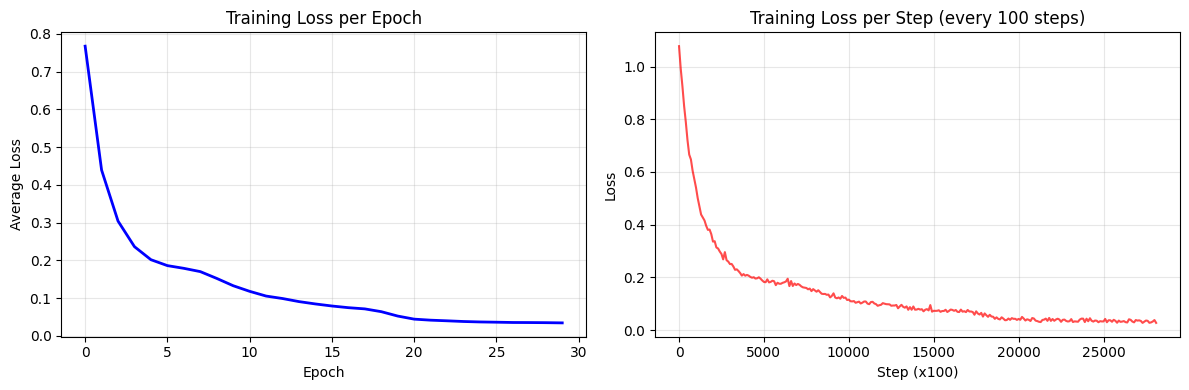

Final average loss: 0.0343
Best loss: 0.0343


In [ ]:
# Plot the training loss
plt.figure(figsize=(12, 4))

# Plot epoch losses
plt.subplot(1, 2, 1)
plt.plot(epoch_losses, 'b-', linewidth=2)
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True, alpha=0.3)

# Plot step losses (every 100 steps for clarity)
plt.subplot(1, 2, 2)
step_indices = range(0, len(step_losses), 100)
plt.plot(step_indices, [step_losses[i] for i in step_indices], 'r-', alpha=0.7)
plt.title('Training Loss per Step (every 100 steps)')
plt.xlabel('Step (x100)')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Final average loss: {epoch_losses[-1]:.4f}")
print(f"Best loss: {min(epoch_losses):.4f}")

### Visualize Denoising Process with Prompt Engineering

Defines a function to generate and display a grid of images showing the denoising step for different text prompts.

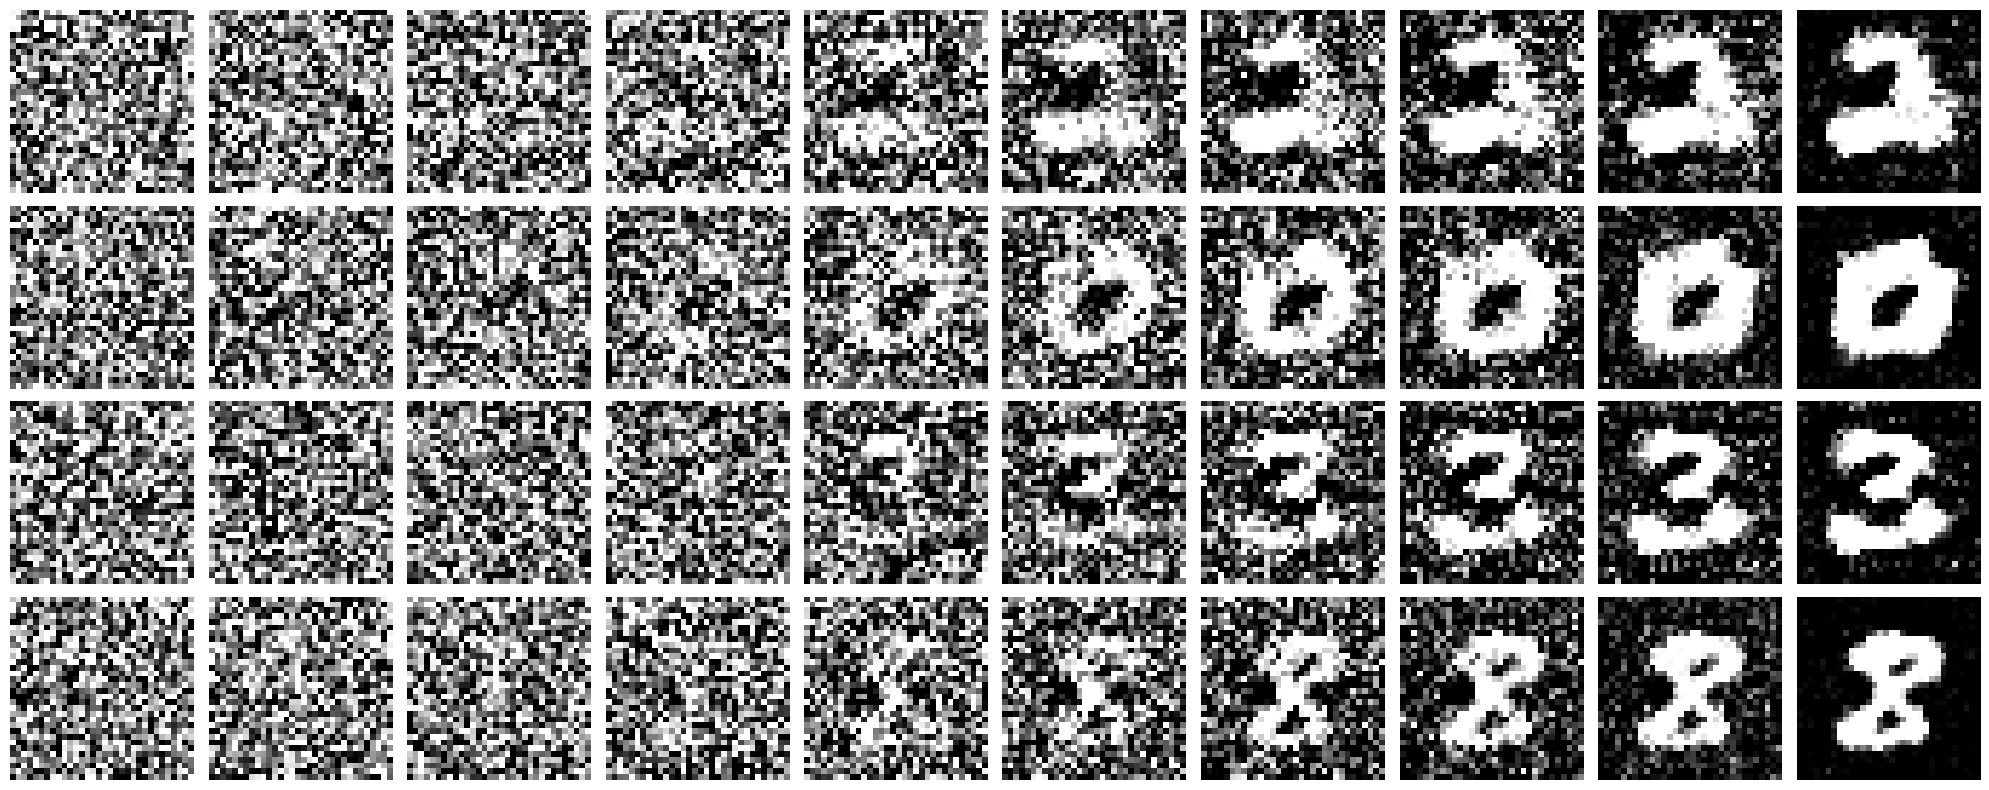

In [ ]:
def sample_ddpm_grid(model, prompts, steps=1000, n_cols=10, guidance_scale=5.0):
    model.eval()
    n_rows = len(prompts)
    step_indices = np.linspace(steps-1, 0, n_cols, dtype=int)

    all_imgs = []
    with torch.no_grad():
        for prompt in prompts:
            context = get_text_embedding([prompt], device)
            null_context = get_text_embedding([""], device)
            x = torch.randn(1, 1, 32, 32).to(device)
            imgs = []
            for t_ in reversed(range(steps)):
                t = torch.full((1,), t_, device=device, dtype=torch.long)
                t_emb = get_timestep_embedding(t, emb_dim).to(device)
                eps = classifier_free_guidance(model, x, t_emb, context, null_context, guidance_scale)
                beta = betas[t_].to(device)
                alpha = alphas[t_].to(device)
                alpha_cumprod_t = alphas_cumprod[t_].to(device)
                if t_ > 0:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = (1 / torch.sqrt(alpha)) * (x - (beta / torch.sqrt(1 - alpha_cumprod_t)) * eps) + torch.sqrt(beta) * noise
                if t_ in step_indices:
                    imgs.append((x[0, 0].cpu().numpy() + 1) / 2)
            all_imgs.append(imgs)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*2, n_rows*2))
    for i in range(n_rows):
        for j in range(n_cols):
            axes[i, j].imshow(all_imgs[i][j], cmap='gray', vmin=0, vmax=1)
            axes[i, j].axis('off')
    plt.tight_layout()
    plt.show()

prompts = [
    "a handwritten number two",
    "a handwritten number zero",
    "a handwritten number three",
    "a handwritten number eight"
]
sample_ddpm_grid(model, prompts, steps=1000, n_cols=10, guidance_scale=10)